In [1]:
# https://developers.google.com/optimization/introduction/python

In [2]:
%reset -sf
import networkx as nx
import matplotlib.pyplot as plt
from ortools.linear_solver import pywraplp

# Define problem

In [3]:
# Define four parallel arrays: start_nodes, end_nodes, capacities, and unit costs
# between each pair. For instance, the arc from node 0 to node 1 has a
# capacity of 15 and a unit cost of 4.

import pandas as pd

edges = pd.DataFrame()
edges["start_nodes"] = [ 0, 0,  1, 1,  1,  2, 2,  3, 4]
edges["end_nodes"]   = [ 1, 2,  2, 3,  4,  3, 4,  4, 2]
edges["unit_costs"]  = [ 4, 4,  2, 2,  6,  1, 3,  2, 3]
edges["capacities"]  = [15, 8, 20, 4, 10, 15, 4, 20, 5]
edges["flows"]       = [ 0, 0,  0, 0,  0,  0, 0,  0, 0]
edges["names"]       = "x"+edges[["start_nodes","end_nodes"]].astype(str).apply(''.join, axis=1)

# Define an array of supplies at each node.
supplies = [20, 0, 0, -5, -15]
num_nodes = len(supplies)

# Generate adjacency matrix

In [4]:
def get_adjacency_matrix(edges):
    start_nodes = edges["start_nodes"]
    end_nodes = edges["end_nodes"]
    unit_costs = edges["unit_costs"]
    capacities = edges["capacities"]
    flows = edges["flows"]
    names = edges["flows"]
    
    matrix_unit_costs = [[0 for _ in range(num_nodes)] for _ in range(num_nodes)]
    matrix_capacities = [[0 for _ in range(num_nodes)] for _ in range(num_nodes)]
    matrix_flows      = [[0 for _ in range(num_nodes)] for _ in range(num_nodes)]
    matrix_names      = [["x"+str(i)+str(j)
                          for i in range(num_nodes)] 
                         for j in range(num_nodes)]
    
    for x,y,z,c,f,n in zip(start_nodes, end_nodes, unit_costs, capacities, flows, names):
        matrix_unit_costs[x][y] = z
        matrix_capacities[x][y] = c
        matrix_flows     [x][y] = f
        
    for y,x,z,c,f,n in zip(start_nodes, end_nodes, unit_costs, capacities, flows, names):
        matrix_unit_costs[x][y] = z
        matrix_capacities[x][y] = c
        matrix_flows     [x][y] = f

    return matrix_unit_costs, matrix_capacities, matrix_flows, matrix_names

matrix_unit_costs, matrix_capacities, matrix_flows, matrix_names = get_adjacency_matrix(edges)

In [5]:
edges["names"]

0    x01
1    x02
2    x12
3    x13
4    x14
5    x23
6    x24
7    x34
8    x42
Name: names, dtype: object

In [6]:
matrix_unit_costs, matrix_capacities, matrix_flows, matrix_names

([[0, 4, 4, 0, 0],
  [4, 0, 2, 2, 6],
  [4, 2, 0, 1, 3],
  [0, 2, 1, 0, 2],
  [0, 6, 3, 2, 0]],
 [[0, 15, 8, 0, 0],
  [15, 0, 20, 4, 10],
  [8, 20, 0, 15, 5],
  [0, 4, 15, 0, 20],
  [0, 10, 4, 20, 0]],
 [[0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0]],
 [['x00', 'x10', 'x20', 'x30', 'x40'],
  ['x01', 'x11', 'x21', 'x31', 'x41'],
  ['x02', 'x12', 'x22', 'x32', 'x42'],
  ['x03', 'x13', 'x23', 'x33', 'x43'],
  ['x04', 'x14', 'x24', 'x34', 'x44']])

In [7]:
def plot_graph(supplies, edges):
    start_nodes = edges["start_nodes"]
    end_nodes = edges["end_nodes"]
    unit_costs = edges["unit_costs"]
    capacities = edges["capacities"]
    flows = edges["flows"]

    G = nx.DiGraph()
    for x,y,z,c,f in zip(start_nodes, end_nodes, unit_costs, capacities, flows):
        G.add_edge(x, y, cost=z, capacity=c, flow=f)

    labeldict = {}
    for i,s in enumerate(supplies):
        labeldict[i] = s

    plt.figure(figsize=(14,10))
    pos=nx.circular_layout(G)
    nx.draw_networkx(G,pos,labels=labeldict, with_labels=True, 
                     arrowsize=20, font_size=15, node_color="yellow")
    nx.draw_networkx_edge_labels(G,pos)
    plt.show()

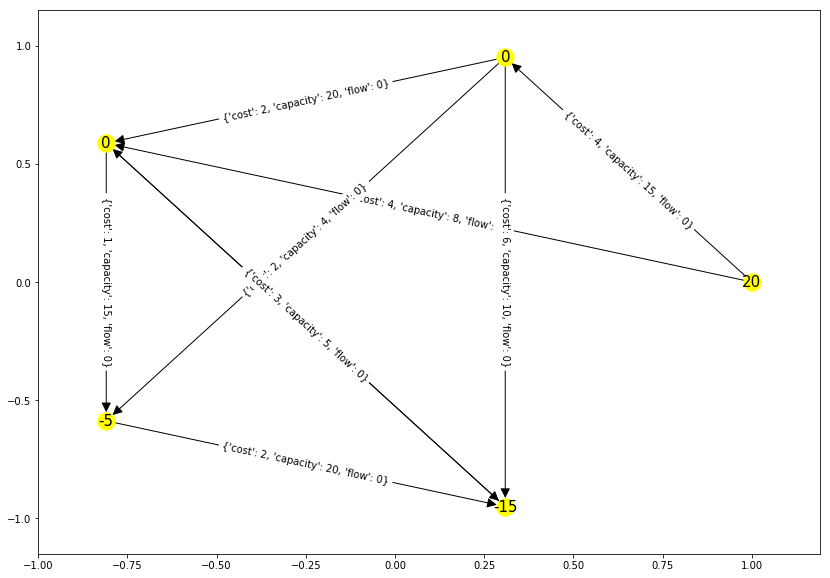

In [8]:
plt.show()
plot_graph(supplies, edges)

# Min-cost flow as a linear program

In [9]:
matrix_names

[['x00', 'x10', 'x20', 'x30', 'x40'],
 ['x01', 'x11', 'x21', 'x31', 'x41'],
 ['x02', 'x12', 'x22', 'x32', 'x42'],
 ['x03', 'x13', 'x23', 'x33', 'x43'],
 ['x04', 'x14', 'x24', 'x34', 'x44']]

In [10]:
solver = pywraplp.Solver('hello_program',
                         pywraplp.Solver.CBC_MIXED_INTEGER_PROGRAMMING)

# define variables and capacities
infinity = solver.infinity()
X = [[solver.IntVar(0.0, matrix_capacities[i][j], 'x'+str(i)+str(j)) 
      for j in range(num_nodes)]
     for i in range(num_nodes)]

# define supplies
for i in range(num_nodes):
    solver.Add(sum([X[i][j] for j in range(num_nodes)])
             - sum([X[j][i] for j in range(num_nodes)])
            == supplies[i])

# define objective
solver.Minimize(sum([sum([matrix_unit_costs[i][j] * X[i][j] 
                          for j in range(num_nodes)])
                     for i in range(num_nodes)]))

# sum[matrix_unit_costs[i][j] * X[i][j] for j in range(num_nodes)]

print('Number of variables =', solver.NumVariables())
print('Number of constraints =', solver.NumConstraints())

Number of variables = 25
Number of constraints = 5


In [11]:
print(solver.ExportModelAsLpFormat(False).replace('\\', '').replace(',_', ','), sep='\n')

 Generated by MPModelProtoExporter
   Name             : hello_program
   Format           : Free
   Constraints      : 5
   Variables        : 25
     Binary         : 0
     Integer        : 25
     Continuous     : 0
Minimize
 Obj: +4 x01 +4 x02 +4 x10 +2 x12 +2 x13 +6 x14 +4 x20 +2 x21 +1 x23 +3 x24 +2 x31 +1 x32 +2 x34 +6 x41 +3 x42 +2 x43 
Subject to
 auto_c_000000000: +1 x01 +1 x02 +1 x03 +1 x04 -1 x10 -1 x20 -1 x30 -1 x40  = 20
 auto_c_000000001: -1 x01 +1 x10 +1 x12 +1 x13 +1 x14 -1 x21 -1 x31 -1 x41  = 0
 auto_c_000000002: -1 x02 -1 x12 +1 x20 +1 x21 +1 x23 +1 x24 -1 x32 -1 x42  = 0
 auto_c_000000003: -1 x03 -1 x13 -1 x23 +1 x30 +1 x31 +1 x32 +1 x34 -1 x43  = -5
 auto_c_000000004: -1 x04 -1 x14 -1 x24 -1 x34 +1 x40 +1 x41 +1 x42 +1 x43  = -15
Bounds
 0 <= x01 <= 15
 0 <= x02 <= 8
 0 <= x03 <= 0
 0 <= x04 <= 0
 0 <= x10 <= 15
 0 <= x12 <= 20
 0 <= x13 <= 4
 0 <= x14 <= 10
 0 <= x20 <= 8
 0 <= x21 <= 20
 0 <= x23 <= 15
 0 <= x24 <= 5
 0 <= x30 <= 0
 0 <= x31 <= 4
 0 <= x32 <= 1

In [12]:
status = solver.Solve()

In [13]:
if status != pywraplp.Solver.OPTIMAL:
    print('The problem does not have an optimal solution.')
    
print('Solution:')
print('Objective value =', solver.Objective().Value())

print('\nAdvanced usage:')
print('Problem solved in %f milliseconds' % solver.wall_time())
print('Problem solved in %d iterations'   % solver.iterations())
print('Problem solved in %d branch-and-bound nodes' % solver.nodes())

Solution:
Objective value = 150.0

Advanced usage:
Problem solved in 70.000000 milliseconds
Problem solved in 0 iterations
Problem solved in 0 branch-and-bound nodes
